## Parameters of Shifting gradient

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from bo_code.BO import generate_initial_data

from rm_code.retention_model import online_system, offline_system
from rm_code.plot_chromatogram import plot_chromatogram, plot_contour_spectrum,  plot_shifting_2D_gradient

from utils.utils import bo_to_rm_2D, check_pars, seed_everything

from tqdm import tqdm
import pandas as pd

import seaborn as sns

In [4]:
sns.set(font_scale=1.5)
sns.set_style('white')


In [5]:
### Set up a 1D retention model

# Set some default parameters for first dimension
t_0_1D = 20 # dead time
t_D_1D = 0.1 # dwell time
N_1D = 1000 # plate number 1D
t_init_1D = 2 # init time

# create dictionary for the above described parameters
settings_1D = {'t_0': t_0_1D, 't_D': t_D_1D, 'N': N_1D, 't_init': t_init_1D}

### Set up a 2D retention model

### Define 2D parameters
N_2D = 5000 # plate number 2D

t_M_2D = 8 #/ 3 # modulation time minutes
t_G_2D = 6#/ 3 # gradient time minutes
t_init_2D = 1 #/ 3 # init time minutes
t_D_2D = 0.01 # dwell time in minutes
t_0_2D = 0.01 # dead time in minutes

# create dictionary for the above described parameters
settings_2D = {'t_M': t_M_2D, 't_G': t_G_2D, 't_init': t_init_2D, 't_D': t_D_2D, 't_0': t_0_2D, 'N': N_2D}

# Try out a 1D gradient
phi_list_1D = [0.1, 0.1, 0.3, 0.7, 1] # phi values
t_list_1D = [0, 10, 25, 50, 104] # time values

# Try out a shifting gradient
phi_init_2D = [0.2, 0.2, 0.4, 0.4, 0.7] # lower bounds of gradient shift
phi_final_2D = [0.4, 0.4, 0.7, 0.7, 1] # upper bounds of gradient shift
t_list_2D = [0, t_0_1D, 40, 80, t_list_1D[-1]] # time points of gradient shift

# maximum allowed times in first and second dimension. compounds that elute after this time are ignored in the objective function evaluation.
max_T = [100, t_M_2D]

# check if the parameters are valid
check_pars(settings_2D, t_list_1D, phi_init_2D, phi_final_2D, t_list_2D)

In [6]:
def plot_shifting_2D_gradient(settings_2D, phi_init, phi_final, t_list):
    """Plots a shifting gradient profile

    Args:
        settings_2D (dict): dictionary containing the settings of the 2D gradient:
            t0 (float): dead time of the 2D gradient
            tI (float): init time of the 2D gradient
            tD (float): dwell time of the 2D gradient
            tG (float): gradient time of the 2D gradient
            tM (float): modulation time of the 2D gradient
        phi_init (list): list of lower bounds of the shifting gradient
        phi_final (list): list of upper bounds of the shifting gradient
        t_list (list): list of time points of the shifting gradient

        Returns:
            fig, ax: matplotlib figure and axis
        """

    t0, tI, tD, tG, tM = settings_2D['t_0'], settings_2D['t_init'], settings_2D['t_D'], settings_2D['t_G'],\
        settings_2D['t_M']
    # initialize figure
    fig,ax = plt.subplots()

    # plot the shifting gradient bounds
    ax.plot(t_list, phi_init, color='tab:blue', label='init')
    ax.plot(t_list, phi_final, color='tab:blue', label='init')

    # set the plot limits
    ax.set_ylim(0, 1)
    ax.set_xlim(0, t_list[-1])

    tau = t0 + tI + tD
    # plot the modulations
    for i in range(int(t_list[-1]//tM)):
        time = i * tM
        ts = [time, time + tau, time + tau + tG, time + tM, time + tM]

        # check between which indices of t_list_2D the time is
        idx = np.searchsorted(t_list, time, side='left')
        # also need to check if the end of the modulation is between the indices
        idx_end = np.searchsorted(t_list, time + tM, side='left')

        # if the modulation ends between the same time segments, we can just use the same slope
        if idx == idx_end:
            phi_init_slope = (phi_init[idx] - phi_init[idx-1]) / (t_list[idx] - t_list[idx-1])
            phi_final_slope = (phi_final[idx] - phi_final[idx-1]) / (t_list[idx] - t_list[idx-1])

            phi_init_init = phi_init_slope * (time - t_list[idx-1]) + phi_init[idx-1]
            phi_init_inter = phi_init_slope * (time + tau - t_list[idx-1]) + phi_init[idx-1]

            phi_init_final = phi_init_slope * (time + tM - t_list[idx-1]) + phi_init[idx-1]

            phi_final_init = phi_final_slope * (time + tG + tau - t_list[idx-1]) + phi_final[idx-1]
            phi_final_inter = phi_final_slope * (time + tM - t_list[idx-1]) + phi_final[idx-1]

            # ax.plot(ts, [phi_init_init, phi_init_inter, phi_final_init, phi_final_init, phi_init_final], color='tab:orange')
            ax.plot(ts, [phi_init_init, phi_init_inter, phi_final_init, phi_final_inter, phi_init_final], color='tab:orange')

        # if this is not the case, we need to be a bit more careful and check at each stage in what shifting segment we are
        # we currently assume that one modulation is at max between two segments, so it assumed that
        # the length of three segments altogether can never be shorter than the modulation time
        else:
            phi_init_slope = (phi_init[idx] - phi_init[idx-1]) / (t_list[idx] - t_list[idx-1])
            phi_init_slope_2 = (phi_init[idx_end] - phi_init[idx_end-1]) / (t_list[idx_end] - t_list[idx_end-1])

            phi_final_slope = (phi_final[idx] - phi_final[idx-1]) / (t_list[idx] - t_list[idx-1])
            phi_final_slope_2 = (phi_final[idx_end] - phi_final[idx_end-1]) / (t_list[idx_end] - t_list[idx_end-1])

            # this always uses the first slope
            phi_init_init = phi_init_slope * (time - t_list[idx-1]) + phi_init[idx-1]

            if time + tau < t_list[idx_end-1]:
                phi_init_inter = phi_init_slope * (time + tau - t_list[idx-1]) + phi_init[idx-1]
            else:
                phi_init_inter = phi_init_slope_2 * (time + tau - t_list[idx_end-1]) + phi_init[idx_end-1]

            if time + tM < t_list[idx_end-1]:
                phi_init_final = phi_init_slope * (time + tM - t_list[idx-1]) + phi_init[idx-1]
            else:
                phi_init_final = phi_init_slope_2 * (time + tM - t_list[idx_end-1]) + phi_init[idx_end-1]

            if time + tG + tau < t_list[idx_end-1]:
                phi_final_init = phi_final_slope * (time + tG + tau - t_list[idx-1]) + phi_final[idx-1]
            else:
                phi_final_init = phi_final_slope_2 * (time + tG + tau - t_list[idx_end-1]) + phi_final[idx_end-1]

            if time + tM < t_list[idx_end-1]:
                phi_final_inter = phi_final_slope * (time + tM - t_list[idx-1]) + phi_final[idx-1]
            else:
                phi_final_inter = phi_final_slope_2 * (time + tM - t_list[idx_end-1]) + phi_final[idx_end-1]

            ax.plot(ts, [phi_init_init, phi_init_inter, phi_final_init, phi_final_inter, phi_init_final], color='tab:orange')
            #ax.plot(ts, [phi_init_init, phi_init_inter, phi_final_init, phi_final_init, phi_init_final], color='tab:orange')

    return fig, ax

20 0.2


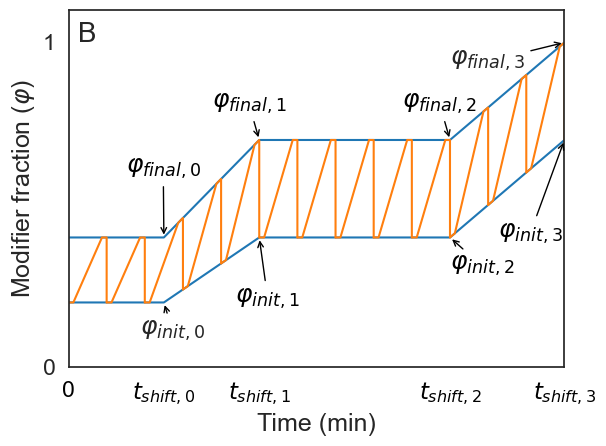

In [65]:
# Set the arrow properties
arrowprops = dict(arrowstyle='->', color='black', mutation_scale=10)
arrowprops_double = dict(arrowstyle='<->', color='black', mutation_scale=10)

color = 'black' #'tab:blue'
plot_shifting_2D_gradient(settings_2D, phi_init_2D, phi_final_2D, t_list_2D)
plt.ylabel('Modifier fraction ($\\varphi$)')
plt.xlabel('Time (min)')
ytick_loc = [0, 1]
ytick_labels = [0, 1]

xtick_loc = t_list_2D
xtick_labels = [0, '$t_{shift ,0}$', '$t_{shift, 1}$', '$t_{shift, 2}$', '$t_{shift, 3}$']
tick_colors = ['black', 'black', color, color, 'black']
plt.xticks(xtick_loc)
plt.gca().set_xticklabels(xtick_labels)

for i, tl in enumerate(plt.gca().get_xticklabels()):
    tl.set_color(tick_colors[i])

plt.yticks(ytick_loc)
plt.gca().set_yticklabels(ytick_labels)

# plt.annotate('$\\varphi_{init, 0}$', (t_list_2D[0], phi_init_2D[0]), (5,0.1), arrowprops=arrowprops)
plt.annotate('$\\varphi_{init, 0}$', (t_list_2D[1], phi_init_2D[1]), (15,0.1), arrowprops=arrowprops)
plt.annotate('$\\varphi_{init, 1}$', (t_list_2D[2], phi_init_2D[2]), (35,0.2), arrowprops=arrowprops, color=color)
plt.annotate('$\\varphi_{init, 2}$', (t_list_2D[3], phi_init_2D[3]), (80,0.3), arrowprops=arrowprops, color=color)
plt.annotate('$\\varphi_{init, 3}$', (t_list_2D[4], phi_init_2D[4]), (90,0.4), arrowprops=arrowprops, color=color)

# plt.annotate('$\\varphi_{final, 0}$', (t_list_2D[0], phi_final_2D[0]), (2,0.5), arrowprops=arrowprops, color=color)
plt.annotate('$\\varphi_{final, 0}$', (t_list_2D[1], phi_final_2D[1]), (12,0.6), arrowprops=arrowprops, color=color)
plt.annotate('$\\varphi_{final, 1}$', (t_list_2D[2], phi_final_2D[2]), (30,0.8), arrowprops=arrowprops, color=color)
plt.annotate('$\\varphi_{final, 2}$', (t_list_2D[3], phi_final_2D[3]), (70,0.8), arrowprops=arrowprops, color=color)
plt.annotate('$\\varphi_{final, 3}$', (t_list_2D[4], phi_final_2D[4]), (80,0.93), arrowprops=arrowprops)

# plt.annotate(' ', xy=(48, 0.38), xytext=(57, 0.38), arrowprops=arrowprops_double, ha='left', va='center')#, va='center')
# plt.annotate('$t_{mod}$', xy=(48, 0.32), xytext=(52, 0.32), ha='center', va='center')
#
# plt.annotate(' ', xy=(48, 0.72), xytext=(55, 0.72), arrowprops=arrowprops_double, ha='left', va='center')#, va='center')
# plt.annotate('$t^{2}_{g}$', xy=(48, 0.79), xytext=(52, 0.79), ha='center', va='center')

print(t_list_2D[1], phi_init_2D[1])
#plt.xlim(0,101)
plt.ylim(0, 1.1)

# set figsize to 6,6


plt.tight_layout()
#plt.show()

# plot a B in the top left
plt.annotate('B', (2, 1.), (2, 1.), fontsize=20)

plt.savefig('figures/examples_2D_pars.png', dpi=500, bbox_inches='tight')
plt.savefig('figures/examples_2D_pars.pdf', dpi=500, bbox_inches='tight')


# plt.vlines(t_list_2D[1:], 0, 1, color='black', ls='dashed')

## 2D gradient with a shift less

In [96]:
### Set up a 1D retention model

# Set some default parameters for first dimension
t_0_1D = 20 # dead time
t_D_1D = 0.1 # dwell time
N_1D = 1000 # plate number 1D
t_init_1D = 2 # init time

# create dictionary for the above described parameters
settings_1D = {'t_0': t_0_1D, 't_D': t_D_1D, 'N': N_1D, 't_init': t_init_1D}

### Set up a 2D retention model

### Define 2D parameters
N_2D = 5000 # plate number 2D

t_M_2D = 8 #/ 3 # modulation time minutes
t_G_2D = 6#/ 3 # gradient time minutes
t_init_2D = 1 #/ 3 # init time minutes
t_D_2D = 0.01 # dwell time in minutes
t_0_2D = 0.01 # dead time in minutes

# create dictionary for the above described parameters
settings_2D = {'t_M': t_M_2D, 't_G': t_G_2D, 't_init': t_init_2D, 't_D': t_D_2D, 't_0': t_0_2D, 'N': N_2D}

# Try out a 1D gradient
phi_list_1D = [0.1, 0.1, 0.3, 0.7, 1] # phi values
t_list_1D = [0, 10, 25, 50, 104] # time values

# Try out a shifting gradient
phi_init_2D = [0.1, 0.1, 0.5, 0.5] # lower bounds of gradient shift
phi_final_2D = [0.4, 0.4, 0.9, 0.9] # upper bounds of gradient shift
t_list_2D = [0, t_0_1D, 62, t_list_1D[-1]] # time points of gradient shift

# maximum allowed times in first and second dimension. compounds that elute after this time are ignored in the objective function evaluation.
max_T = [100, t_M_2D]

# check if the parameters are valid
check_pars(settings_2D, t_list_1D, phi_init_2D, phi_final_2D, t_list_2D)

20 0.1


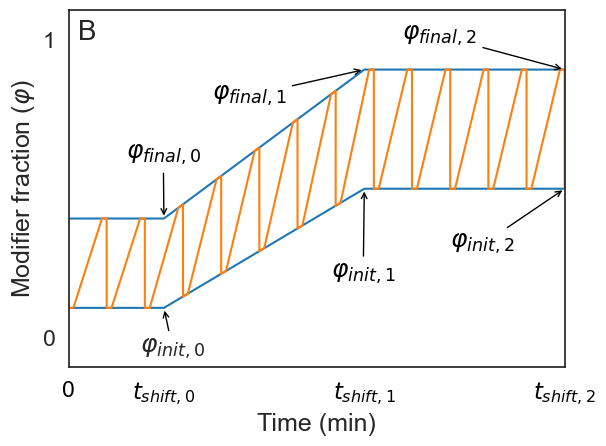

In [107]:
# Set the arrow properties
arrowprops = dict(arrowstyle='->', color='black', mutation_scale=10)
arrowprops_double = dict(arrowstyle='<->', color='black', mutation_scale=10)

color = 'black' #'tab:blue'
plot_shifting_2D_gradient(settings_2D, phi_init_2D, phi_final_2D, t_list_2D)
plt.ylabel('Modifier fraction ($\\varphi$)')
plt.xlabel('Time (min)')
ytick_loc = [0, 1]
ytick_labels = [0, 1]

xtick_loc = t_list_2D
xtick_labels = [0, '$t_{shift ,0}$', '$t_{shift, 1}$', '$t_{shift, 2}$']#, '$t_{shift, 3}$']
tick_colors = ['black', 'black', color, 'black']
plt.xticks(xtick_loc)
plt.gca().set_xticklabels(xtick_labels)

for i, tl in enumerate(plt.gca().get_xticklabels()):
    tl.set_color(tick_colors[i])

plt.yticks(ytick_loc)
plt.gca().set_yticklabels(ytick_labels)

# plt.annotate('$\\varphi_{init, 0}$', (t_list_2D[0], phi_init_2D[0]), (5,0.1), arrowprops=arrowprops)
plt.annotate('$\\varphi_{init, 0}$', (t_list_2D[1], phi_init_2D[1]), (15,-0.05), arrowprops=arrowprops)
plt.annotate('$\\varphi_{init, 1}$', (t_list_2D[2], phi_init_2D[2]), (55,0.2), arrowprops=arrowprops, color=color)
plt.annotate('$\\varphi_{init, 2}$', (t_list_2D[3], phi_init_2D[3]), (80,0.3), arrowprops=arrowprops, color=color)
#plt.annotate('$\\varphi_{init, 3}$', (t_list_2D[4], phi_init_2D[4]), (90,0.4), arrowprops=arrowprops, color=color)

# plt.annotate('$\\varphi_{final, 0}$', (t_list_2D[0], phi_final_2D[0]), (2,0.5), arrowprops=arrowprops, color=color)
plt.annotate('$\\varphi_{final, 0}$', (t_list_2D[1], phi_final_2D[1]), (12,0.6), arrowprops=arrowprops, color=color)
plt.annotate('$\\varphi_{final, 1}$', (t_list_2D[2], phi_final_2D[2]), (30,0.8), arrowprops=arrowprops, color=color)
plt.annotate('$\\varphi_{final, 2}$', (t_list_2D[3], phi_final_2D[3]), (70,1.0), arrowprops=arrowprops, color=color)
#plt.annotate('$\\varphi_{final, 3}$', (t_list_2D[4], phi_final_2D[4]), (80,0.93), arrowprops=arrowprops)

# plt.annotate(' ', xy=(48, 0.38), xytext=(57, 0.38), arrowprops=arrowprops_double, ha='left', va='center')#, va='center')
# plt.annotate('$t_{mod}$', xy=(48, 0.32), xytext=(52, 0.32), ha='center', va='center')
#
# plt.annotate(' ', xy=(48, 0.72), xytext=(55, 0.72), arrowprops=arrowprops_double, ha='left', va='center')#, va='center')
# plt.annotate('$t^{2}_{g}$', xy=(48, 0.79), xytext=(52, 0.79), ha='center', va='center')

print(t_list_2D[1], phi_init_2D[1])
#plt.xlim(0,101)
plt.ylim(-0.1, 1.1)

# set figsize to 6,6


plt.tight_layout()
#plt.show()

# plot a B in the top left
plt.annotate('B', (2, 1.), (2, 1.), fontsize=20)

plt.savefig('figures/examples_2D_pars_real.png', dpi=500, bbox_inches='tight')
plt.savefig('figures/examples_2D_pars_real.pdf', dpi=500, bbox_inches='tight')


# plt.vlines(t_list_2D[1:], 0, 1, color='black', ls='dashed')

### 1D gradient program

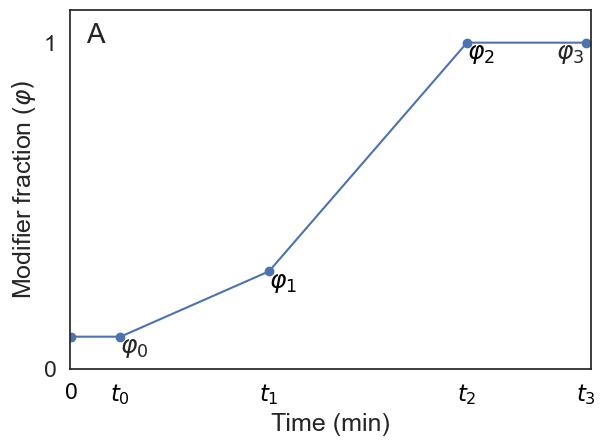

In [87]:
fig, ax = plt.subplots(1, 1)#, figsize=(6,6))


ax.set_xlabel('Time (min)')

ytick_loc = [0, 1]
ytick_labels = [0, 1]

plt.yticks(ytick_loc)
plt.gca().set_yticklabels(ytick_labels)

# Try out a 1D gradient
phi_list_1D = [0.1, 0.1, 0.3, 1, 1] # phi values
t_list_1D = [0, 10, 40, 80, 104] # time values
ax.plot(t_list_1D, phi_list_1D)#, c='black', zorder=1)
ax.scatter(t_list_1D, phi_list_1D)
xtick_loc = t_list_1D
xtick_labels = [0, '$t_0$', '$t_{1}$', '$t_2$', '$t_{3}$']
tick_colors = ['black', 'black', color, color, 'black']
plt.xticks(xtick_loc)
plt.gca().set_xticklabels(xtick_labels)

for i, tl in enumerate(plt.gca().get_xticklabels()):
    tl.set_color(tick_colors[i])

plt.yticks(ytick_loc)
plt.gca().set_yticklabels(ytick_labels)
# ax.set_xlabel('$\\varphi_2$', fontsize=fs)

plt.annotate('$\\varphi_{0}$', (t_list_1D[1], phi_list_1D[1]), (t_list_1D[1]-0.05 , phi_list_1D[1]-0.05))
plt.annotate('$\\varphi_{1}$', (t_list_1D[2], phi_list_1D[2]), (t_list_1D[2]-0.05, phi_list_1D[2]-0.05), color=color)
plt.annotate('$\\varphi_{2}$', (t_list_1D[3], phi_list_1D[3]), (t_list_1D[3]-0.05, phi_list_1D[3]-0.05), color=color)
plt.annotate('$\\varphi_{3}$', (t_list_1D[4], phi_list_1D[4]), (t_list_1D[4]-6, phi_list_1D[4]-0.05))


ax.set_ylabel("Modifier fraction ($\\varphi)$")
# ax.set_ylabel('$\\varphi_1$', fontsize=fs)

# np.savetxt('data_for_bob/Fig2_params_of_gradient_program/grad_prog.csv', np.transpose([time_matrix, phi_matrix]), delimiter=',')
plt.xlim(-0.3,105)
plt.ylim(0,1.1)
plt.tight_layout()

# plot an A in the top left
plt.annotate('A', (3, 1.), (3, 1.), fontsize=20)

plt.savefig('figures/example_pars_1D.pdf', dpi=500, bbox_inches='tight')
plt.savefig('figures/example_pars_1D.png', dpi=500, bbox_inches='tight')

plt.show()



## 1D gradient program as in real system

Actually, scratch this, the upper plots are actually correct. we just fix t0, phi0, t2, phi2 and t3 phi3

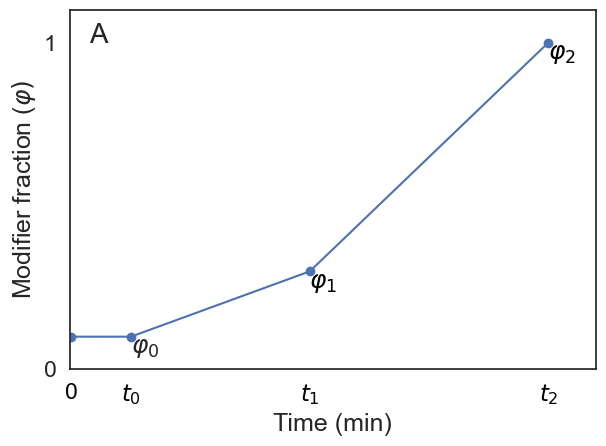

In [79]:
# fig, ax = plt.subplots(1, 1)#, figsize=(6,6))
#
#
# ax.set_xlabel('Time (min)')
#
# ytick_loc = [0, 1]
# ytick_labels = [0, 1]
#
# plt.yticks(ytick_loc)
# plt.gca().set_yticklabels(ytick_labels)
#
# # Try out a 1D gradient
# phi_list_1D = [0.1, 0.1, 0.3, 1] # phi values
# t_list_1D = [0, 10, 40, 80] # time values
# ax.plot(t_list_1D, phi_list_1D)#, c='black', zorder=1)
# ax.scatter(t_list_1D, phi_list_1D)
# xtick_loc = t_list_1D
# xtick_labels = ['0', '$t_{0}$', '$t_1$', '$t_{2}$']
# tick_colors = ['black', 'black', color, 'black']
# plt.xticks(xtick_loc)
# plt.gca().set_xticklabels(xtick_labels)
#
# for i, tl in enumerate(plt.gca().get_xticklabels()):
#     tl.set_color(tick_colors[i])
#
# plt.yticks(ytick_loc)
# plt.gca().set_yticklabels(ytick_labels)
# # ax.set_xlabel('$\\varphi_2$', fontsize=fs)
#
# plt.annotate('$\\varphi_{0}$', (t_list_1D[1], phi_list_1D[1]), (t_list_1D[1]-0.05 , phi_list_1D[1]-0.05))
# plt.annotate('$\\varphi_{1}$', (t_list_1D[2], phi_list_1D[2]), (t_list_1D[2]-0.05, phi_list_1D[2]-0.05), color=color)
# plt.annotate('$\\varphi_{2}$', (t_list_1D[3], phi_list_1D[3]), (t_list_1D[3]-0.05, phi_list_1D[3]-0.05), color=color)
# #plt.annotate('$\\varphi_{3}$', (t_list_1D[4], phi_list_1D[4]), (t_list_1D[4]-6, phi_list_1D[4]-0.05))
#
# ax.set_ylabel("Modifier fraction ($\\varphi)$")
# # ax.set_ylabel('$\\varphi_1$', fontsize=fs)
#
# # np.savetxt('data_for_bob/Fig2_params_of_gradient_program/grad_prog.csv', np.transpose([time_matrix, phi_matrix]), delimiter=',')
# plt.xlim(-0.3,88)
# plt.ylim(0,1.1)
# plt.tight_layout()
#
# # plot an A in the top left
# plt.annotate('A', (3, 1.), (3, 1.), fontsize=20)
#
# plt.savefig('figures/example_pars_1D_real.pdf', dpi=500, bbox_inches='tight')
# plt.savefig('figures/example_pars_1D_real.png', dpi=500, bbox_inches='tight')
#
# plt.show()

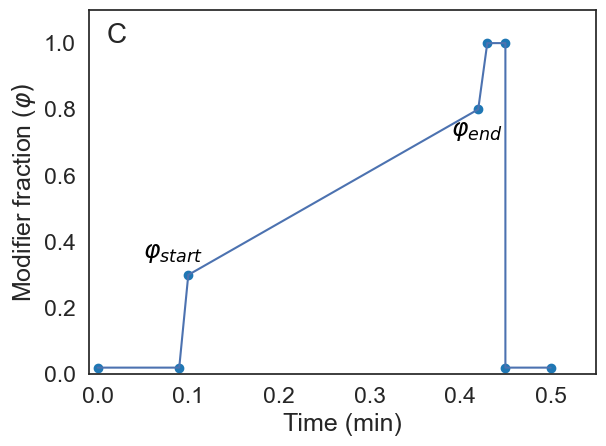

In [69]:
# 2D gradient program
fig, ax = plt.subplots(1, 1)#, figsize=(6,6))

ax.set_xlabel('Time (min)')

# ytick_loc = [0, 1]
# ytick_labels = [0, 1]
#
# plt.yticks(ytick_loc)
# plt.gca().set_yticklabels(ytick_labels)

# Try out a 1D gradient
phi_list_1D = [0.02, 0.02, 0.3, 0.8, 1, 1, 0.02, 0.02] # phi values
t_list_1D = [0, 0.09, 0.1, 0.42, 0.43, 0.45, 0.45, 0.50] # time values
ax.plot(t_list_1D, phi_list_1D)#, c='black', zorder=1)
#ax.scatter(t_list_1D[2:-4], phi_list_1D[2:-4])
ax.scatter(t_list_1D, phi_list_1D, color='tab:blue')
#xtick_loc = t_list_1D
#xtick_labels = [0, '$t_0$', '$t_{1}$', '$t_2$', '$t_{3}$']
#tick_colors = ['black', 'black', color, color, 'black']
##plt.xticks(xtick_loc)
#plt.gca().set_xticklabels(xtick_labels)

#for i, tl in enumerate(plt.gca().get_xticklabels()):
 #   tl.set_color(tick_colors[i])

# plt.yticks(ytick_loc)
# plt.gca().set_yticklabels(ytick_labels)
# ax.set_xlabel('$\\varphi_2$', fontsize=fs)
#
# plt.annotate('$\\varphi_{0}$', (t_list_1D[1], phi_list_1D[1]), (t_list_1D[1]-0.05 , phi_list_1D[1]-0.05))
plt.annotate('$\\varphi_{start}$', (t_list_1D[2], phi_list_1D[2]), (t_list_1D[2]-0.05, phi_list_1D[2]+0.05), color=color)
plt.annotate('$\\varphi_{end}$', (t_list_1D[3], phi_list_1D[3]), (t_list_1D[3]-0.03, phi_list_1D[3]-0.08), color=color)
# plt.annotate('$\\varphi_{3}$', (t_list_1D[4], phi_list_1D[4]), (t_list_1D[4]-6, phi_list_1D[4]-0.05))


ax.set_ylabel("Modifier fraction ($\\varphi)$")
# ax.set_ylabel('$\\varphi_1$', fontsize=fs)

# np.savetxt('data_for_bob/Fig2_params_of_gradient_program/grad_prog.csv', np.transpose([time_matrix, phi_matrix]), delimiter=',')
plt.xlim(-0.01,0.55)
plt.ylim(0,1.1)
plt.tight_layout()

# place a C in the top left
plt.annotate('C', (0.01, 1.), (0.01, 1.), fontsize=20)

plt.savefig('figures/example_pars_2D_sep_program.pdf', dpi=500, bbox_inches='tight')
plt.savefig('figures/example_pars_2D_sep_program.png', dpi=500, bbox_inches='tight')

plt.show()

In [12]:
score_files = !ls data/results_old/pwl*_scores_all_online*
scores_files_st = !ls data/results_old/scores_all_single_task*
scores_random = !ls data/results_old/*scores_all_random*

# add the files
score_files += scores_files_st
score_files += scores_random

In [17]:
# import some result files
# just to refresh myself
# scores_all is single task GP
# thomp is thompson sampling
# maxu is with max_utility
# debug is using same online as offline model
# pwl is piecewise linear as online vs offline model
# nothing mentioned is using UCB

# scores file is set up as follows:
# iterations on columns and repeats on rows
# best so far sorting is not done yet
%matplotlib inline

from utils.utils import best_so_far, ci
for sf in score_files:
    scores = np.load(sf)
    bsf = best_so_far(scores)
    plt.plot(bsf.T.mean(axis=1), label=sf)
    plt.fill_between(np.arange(scores.shape[1]), bsf.T.mean(axis=1) - ci(bsf, scores.shape[0]) , bsf.T.mean(axis=1) + ci(bsf, scores.shape[0]), alpha=0.2)
    plt.legend()
    plt.show()

